In [54]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tqdm.notebook import tqdm

from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from IPython.display import display, Javascript
from base64 import b64decode
from tensorflow.keras.layers import LeakyReLU, Input, Conv2D, AveragePooling2D, Flatten, Dense,BatchNormalization,Normalization, Dropout,GlobalAveragePooling2D



import matplotlib.pyplot as plt

In [55]:
from keras.models import load_model

age_model = load_model("age_model_aug.h5",
                                       compile=False)
gender_model = load_model('gender_model_relu.h5',
                                       compile=False)
emotion_model = load_model('emotion_model.h5',
                                       compile=False)

In [56]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade

< cv2.CascadeClassifier 000001BFCBD948F0>

In [57]:
age_classes=['1-2','3-9','10-20','21-27','28-45','46-65','+66']
gender_classes=['Man','Woman']
emotions_classes=['Anger',"Disgust","Fear","Happiness","Sadness","Surprise"]

In [58]:
BASE_DIR ="C:/Users/Nidhal Jegham/Facial Recognition Project/UTKFace"


In [59]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [60]:
image_path= image_paths[14595] 

In [61]:
nidhal_path= "C:/Users/Nidhal Jegham/Facial Recognition Project/nidhal.jpg"


In [67]:


def shrink_face_roi(x, y, w, h, scale=0.9):
    wh_multiplier = (1-scale)/2
    x_new = int(x + (w * wh_multiplier))
    y_new = int(y + (h * wh_multiplier))
    w_new = int(w * scale)
    h_new = int(h * scale)
    return (x_new, y_new, w_new, h_new)



def create_age_text(img, face_age, face_gender, pct_age,face_expression, x, y, w, h):

    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    text_scale = 1.2
    pct_age_scale = 1.2

    (age_text_width, age_text_height), text_bsln = cv2.getTextSize(face_age, fontFace=fontFace, fontScale=text_scale, thickness=1)
    (pct_age_width, pct_age_height), pct_age_bsln = cv2.getTextSize(pct_age, fontFace=fontFace, fontScale=text_scale, thickness=1)
    (gender_text_width, gender_text_height), gender_text_bsln = cv2.getTextSize(face_gender, fontFace=fontFace, fontScale=text_scale, thickness=1)
    (emotion_text_width, emotion_text_height), emotion_text_bsln = cv2.getTextSize(face_expression, fontFace=fontFace, fontScale=text_scale, thickness=1)

    x_center = x + (w/2)
    y_gender_text_center = y +h+20

    y_text_center = y + h + 55
    y_emotion_text_center=y+h+90
    pct_age_center = y + h+125

    x_text_org = int(round(x_center - (age_text_width / 2)))
    y_text_org = int(round(y_text_center + (age_text_height / 2)))
    x_pct_age_org = int(round(x_center - (pct_age_width / 2)))
    y_pct_age_org = int(round(pct_age_center + (pct_age_height / 2)))
    x_gender_text_org = int(round(x_center - (gender_text_width / 2)))
    y_gender_text_org = int(round(y_gender_text_center + (gender_text_height / 2)))
    x_emotion_text_org = int(round(x_center - (emotion_text_width / 2)))
    y_emotion_text_org = int(round(y_emotion_text_center + (emotion_text_height / 2)))

    face_age_background = cv2.rectangle(img, (x-1, y+h), (x+w+1, y+h+150), (0, 100, 0), cv2.FILLED)
    face_gender_text = cv2.putText(img, face_gender, org=(x_gender_text_org, y_gender_text_org), fontFace=fontFace, fontScale=text_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)
    face_age_text = cv2.putText(img, face_age, org=(x_text_org, y_text_org), fontFace=fontFace, fontScale=text_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)
    pct_age_text = cv2.putText(img, pct_age, org=(x_pct_age_org, y_pct_age_org), fontFace=fontFace, fontScale=text_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)
    face_emotion_text = cv2.putText(img, face_expression, org=(x_emotion_text_org, y_emotion_text_org), fontFace=fontFace, fontScale=text_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)

    return (face_age_background, face_age_text, face_gender_text,face_emotion_text)



def classify_age(img):

    img_copy = np.copy(img)
    img_copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_copy_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(img_copy, scaleFactor=1.2, minNeighbors=6, minSize=(100, 100))
    for i, (x, y, w, h) in enumerate(faces):

        face_rect = cv2.rectangle(img_copy_rgb, (x, y), (x+w, y+h+90), (0, 100, 0), thickness=2)
        x2, y2, w2, h2 = shrink_face_roi(x, y, w, h)
        face_roi_rgb = img_copy_rgb[y2:y2+h2, x2:x2+w2]
        face_roi_rgb = cv2.resize(face_roi_rgb, (128, 128))

        face_roi_gray = img_copy_gray[y2:y2+h2, x2:x2+w2]
        face_roi_gray = cv2.resize(face_roi_gray, (128, 128))

        features_rgb = []
        face_roi_rgb = np.array(face_roi_rgb)
        face_roi_rgb=face_roi_rgb/255
        features_rgb.append(face_roi_rgb)
        features_rgb=np.array(features_rgb)

        features_gray = []
        face_roi_gray = np.array(face_roi_gray)
        face_roi_rgb=face_roi_gray/255
        features_gray.append(face_roi_gray)
        features_gray=np.array(features_gray)

        face_age = age_classes[np.argmax(age_model.predict(features_gray))]
        face_age= face_age+' Years Old'
        face_expression=emotions_classes[np.argmax(emotion_model.predict(features_rgb))]
        face_gender = gender_classes[np.argmax(gender_model.predict(features_rgb))]
        pct_age = np.max(age_model.predict(features_gray))

        face_age_background, face_age_text, face_gender,face_emotion = create_age_text(img_copy, face_age, face_gender, str(pct_age),face_expression, x, y, w, h)

    return img_copy




def new_img_name(org_img_path):
    img_path, img_name_ext = os.path.split(org_img_path)
    img_name, img_ext = os.path.splitext(img_name_ext)

    new_img_name_ext = img_name+"_Analyzed"+img_ext
    new_img_path = os.path.join(img_path, new_img_name_ext)

    return new_img_path




def new_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_Analyzed"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [77]:
nidhal_path="Firas.jpg"


1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


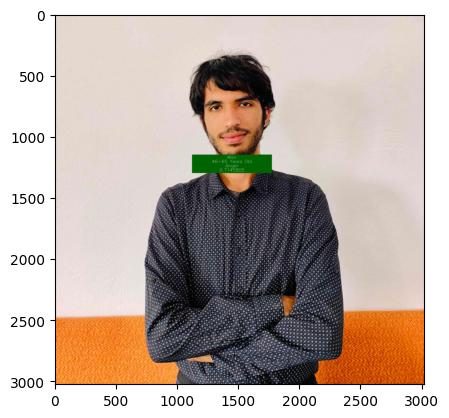

In [79]:


img = cv2.imread(nidhal_path)
age_img = classify_age(img)
plt.imshow(age_img)





In [80]:
try:
    new_my_image = new_img_name(nidhal_path)
    age_img_rgb = cv2.cvtColor(age_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(new_my_image, age_img_rgb)

    print(f"Saved to {new_my_image}")
except:
    print("Error: Could not save image!")



Saved to Firas_WITH_AGE.jpg


  0%|          | 0/23708 [00:00<?, ?it/s]

In [81]:
my_video = "Ma Iyed.mp4"

In [ ]:

cap = cv2.VideoCapture(my_video)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    if ret==True:
        
        age_img = classify_age(frame)
        age_img = cv2.cvtColor(age_img, cv2.COLOR_BGR2RGB)
       
        out.write(age_img)

    else:
        break

cap.release()
out.release()
print(f"Saved to {new_my_video}")

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36m